## Environment setup

### Library preparation

In [23]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import time, os, io
from PIL import ImageGrab
from IPython.display import Image, display
import clipboard
from scipy import stats
from si_prefix import si_format
from tqdm import tqdm, tqdm_notebook

import pandas as pd
import numpy as np
from io import StringIO 
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
plt.close('all')

import sys 
sys.path.append('..')
from meas_util import *

import qcodes as qc
from qcodes import Station, load_by_run_spec, load_by_guid
from qcodes.instrument.base import Instrument
from qcodes.dataset.experiment_container import (Experiment,
                                                 load_last_experiment,
                                                 new_experiment)
from qcodes.dataset.database import initialise_database
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id, get_data_by_id, plot_dataset
from qcodes.dataset.data_set import load_by_id
# from qcodes.dataset.data_export import get_shaped_data_by_runidb

C:\Users\KelvinOX25\Anaconda3\lib\site-packages\qcodes\dataset\database.py:13: UserWarning: The module `qcodes.dataset.database` is deprecated.
Public features are available at the import of `qcodes`.
Private features are available in `qcodes.dataset.sqlite.*` modules.
  warnings.warn('The module `qcodes.dataset.database` is deprecated.\n'


In [3]:
from qcodes.instrument_drivers.Lakeshore.Model_372 import Model_372
from qcodes.instrument_drivers.tektronix.AWG3252_Isrc import AWG3252_Isrc
from qcodes.instrument_drivers.HP.HP34401 import HP34401
from qcodes.instrument_drivers.HP.HP34401_DL1201 import HP34401_DL1201
from qcodes.instrument_drivers.Keithley.Keithley_2600_channels import *
from qcodes.instrument_drivers.tektronix.AWG5204_Isrc import AWG5204_Isrc

from qcodes.instrument_drivers.Keysight.Keysight_B2962A_Isrc import B2962A_Isrc


from qcodes.instrument_drivers.Keithley.Keithley_6220 import Keithley_6220

### Instrument nicknames and QC database initialization

In [4]:
try:
   Instrument.close_all()
except KeyError:
   pass    
except NameError:
   pass 

K2602 =  Keithley_2600(name = 'K2602', address = "GPIB::26::INSTR" )
Flux_chA = K2602.smua.curr
Flux_chB = K2602.smub.curr
Bfield =  Flux_chA
Bfield.step = 10e-6
Bfield.inter_delay = .1

LS370 = Model_372(name = 'LS370 input Ch', address = 'GPIB::12::INSTR', terminator='\n')
T8 = LS370.ch08.temperature

htr = LS370htr()
htr.Tset(0.030)
htr.PIDset(30,5,1)
htr.HTRset('off')

# Isrc = AWG5204_Isrc('gen', 'TCPIP0::AWG52000-XXXX::inst0::INSTR', ch = 1, R_bias = 1e9, Attn = 1, timeout = 20)
Isrc = Keithley_6220(name = 'K6220', address = "GPIB::13::INSTR" )
# Isrc = B2962A_Isrc(name = 'B2962A', address = "GPIB::23::INSTR" )
# Isrc = AWG3252_Isrc('gen', 'TCPIP0::192.168.13.32::inst0::INSTR',  R_bias = 1e9, Attn = 1)
# Isrc.init()

Vmeter = HP34401_DL1201('meter', 'GPIB0::8::INSTR', Gain = 100)
Vmeter.init('fast 6')

station = qc.Station(Isrc, Vmeter)

print ('Instrument initialization completed.')

Connected to: Keithley Instruments Inc. 2602A (serial:1272049, firmware:2.1.5) in 0.40s
Connected to: LSCI 370 (serial:370665, firmware:04102008) in 0.10s
initialization \\JOSH-PC\Gersh_Labview\DC measurement\LSCI 370 PYTHON_conf.vi
Instrument initialization completed.


### Database ini

In [5]:
SAMPLE = 'Q097MD'
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)

## Scripts

### Utilities

In [6]:
def setup():
    Isrc.I.set(0)

def cleanup():
    Isrc.I.set(0) 
    Bfield.set(0)
    
def status_now():
    print(Isrc)
    print(Vmeter)
    print('B = {}A'.format(si_format(Bfield.get())))
    print('T = {}K'.format(si_format(T8.get())))
    print('{}\n{}'.format(htr.HTRget(), htr.PWRget()))

In [7]:
def meas_Voffset(i):
    V_off = 0
    N = 10
    Isrc.I.set(i)


    for j in range(N):
#         time.sleep(.1)
        V_off += Vmeter.V.get()
    return V_off/N

In [8]:
def cos_to_B(cos, ZF = .004e-3, FF = .232e-3):

    return np.arccos(cos)*(2* (FF - ZF)/np.pi + ZF  )

In [9]:
def T_scan(T_list):

    tolerT8 = 0.02
    chkrepeat = 20
    chkperiod_sec = 2

    Tnow_alllst = []
    timer_lst = []

    htr.HTRset('10mA')

    for setT8 in setT8_lst:
    #     htr.setpoint(setT8)
        htr.Tset(setT8)
        print('ramping T8 to {}K...'.format(si_format(setT8)))
        if setT8 < 60e-3:
            time.sleep(300)
        else:
            time.sleep(30)
        Tnow_lst = []

        t0 = time.time()
        count_T = 0
        while count_T < chkrepeat:
            T_now = T8.get()
            if (1-tolerT8)*setT8 <= T_now <= (1+tolerT8)*setT8 :
                count_T +=1
                Tnow_lst.append(T_now)
                time.sleep(chkperiod_sec)
            elif count_T >= 1 :
                count_T -=1
        t1 = time.time()

        timer_lst.append(t1-t0)
        Tnow_alllst.append(Tnow_lst)






In [10]:
def RTc (dataPts = 100, Gain = 100, R_bias = 1e9, Attn = 1, tfsstb = 0.1, I_bias = 0.4e-9, T_str = 0):
    
    meas = set_meas(Vmeter.V, Isrc.I, setup = setup, cleanup = cleanup)

    Vmeter.set_Gain ( Gain )
    Isrc.set_R_Attn ( R_bias, Attn )
    pts_list = np.arange(1, dataPts)
    tpts_list = tqdm_notebook(pts_list)

    name_exp(sample = SAMPLE, exp_type = 'RTc')
    with meas.run() as datasaver:
        for j in tpts_list:

            Ib_list = udu_list(1*I_bias, 0.5*I_bias)
            V1_list = []
            T8_lst = []
            for Ib in Ib_list:
                Isrc.I.set(Ib)
                time.sleep(tfsstb)
                V1_list = np.append(V1_list, Vmeter.V.get())
                T8_lst.append(T8.get())
            T_now = sum(T8_lst)/len(T8_lst)
            R_now, intercept, r_value, p_value, std_err = stats.linregress(Ib_list, V1_list)
            
            res = [( Isrc.I, T_now ), ( Vmeter.V, R_now )]
            with open('CH0 T {}.log'.format(time.strftime('%d-%m-%y', time.localtime())),'a+') as fp:
                fp.write(time.strftime(' %d-%m-%y,%H:%M:%S,{}'.format(R_now), time.localtime())+'\n')
                fp.close
            with open('CH8 T {}.log'.format(time.strftime('%d-%m-%y', time.localtime())),'a+') as fp:
                fp.write(time.strftime(' %d-%m-%y,%H:%M:%S,{}'.format(T_now), time.localtime())+'\n')
                fp.close

#             print('Current T8= {}K'.format(si_format(T8.get()), end='\r'))
            sys.stdout.write("\rCurrent T8= {}K".format(si_format(T8.get())))
            sys.stdout.flush()
            datasaver.add_result(*res)
            if T_str == 300:
                time.sleep(54.5)
            else:
                time.sleep(0.05)

    cleanup()
    return datasaver.run_id 

### IVCs

In [11]:
def IVC_udu (amp, stp, Gain, R_bias, Attn, tfsstb = 0.1, label = ''):
    
    
    Voff =  meas_Voffset(0)
    
    meas = set_meas(Vmeter.V, Isrc.I, setup = setup, cleanup = cleanup)

    Vmeter.set_Gain ( Gain )
    Isrc.set_R_Attn ( R_bias, Attn )
    
    i_list = udu_list(amp, stp)
    ti_list = tqdm_notebook(i_list)
    if label == '':
        label = 'IVc @T={}K, B={}A'.format(si_format(T8.get()), si_format(Bfield.get(), precision = 3))
        

    name_exp(sample = SAMPLE, exp_type = label )
    with meas.run() as datasaver:
        for i in ti_list:
            
            Isrc.I.set(i)
            time.sleep(tfsstb)
            V = Vmeter.V.get()

            res = [( Isrc.I, i - 0*22.5e-3/R_bias*Attn ), ( Vmeter.V, V - Voff  )]
            datasaver.add_result(*res) 

    cleanup()
    return datasaver.run_id 

In [12]:
def Ic_meas (amp, stp, thr, Gain, R_bias, Attn, tfsstb = 0.1):

    meas = set_meas(Vmeter.V, Isrc.I, setup = setup, cleanup = cleanup)
    Vmeter.set_Gain (Gain) 
    Isrc.set_R_Attn (R_bias, Attn)
    
    i_list_u = np.linspace(0,  amp,  round (amp/stp) + 1)
    ti_list_u = tqdm_notebook(i_list_u)
    i_list_d = np.linspace(0, -amp,  round (amp/stp) + 1)    
    ti_list_d = tqdm_notebook(i_list_d)
    ti_lists = [ ti_list_u ,  ti_list_d]
    
    name_exp(sample = SAMPLE, exp_type = 'sc branch @T={}K, B={}A'.format(si_format(T8.get()), si_format(B, precision = 3)))
    with meas.run() as datasaver:
        for ti_list in ti_lists:
            
            Isrc.I.set(0)
            V_ = Vmeter.V.get()            
            time.sleep(1)
            
            for i in ti_list:
            
                Isrc.I.set(i)
                time.sleep(tfsstb)

                V = Vmeter.V.get()
                dV = V - V_
                V_ = V 
                
                if (abs(dV) > thr)  or (abs(V) > 4e-3 ) : #
                    break

                res = [( Isrc.I, i - 22.5e-3/R_bias*Attn ), ( Vmeter.V, V  )]
                datasaver.add_result(*res) 
    cleanup()
    return datasaver.run_id 

In [13]:
def IVcB_meas (i_list, B_list, thr=1e-3, Gain=100, R_bias=1e9, Attn=1, tfsstb = 0.1):

    Vmeter.set_Gain (Gain = Gain) 
    Isrc.set_R_Attn (R_bias = R_bias, Attn=Attn)

    i_lists = [i_list]
    
    meas = set_meas(Vmeter.V, Isrc.I,setup = setup, cleanup = cleanup)
    tB_list = tqdm_notebook(B_list)
    for B in tB_list:

        name_exp(sample = SAMPLE, exp_type = 'full IVc(B) @T={}K, B={}A'.format(si_format(T8.get()), si_format(B, precision =3)))
        with meas.run() as datasaver:

            Bfield.set(B)
            for i_list in i_lists:

                Isrc.I.set(0)
                V_ = Vmeter.V.get()
                time.sleep(1)

                for i in i_list:

                    Isrc.I.set(i)
                    time.sleep(tfsstb)

                    V = Vmeter.V.get()
                    dV = V - V_
                    V_ = V

                    if  (abs(V) > 6.4e-3) : #(abs(dV) > thr)  or
                        break

                    res = [( Isrc.I, i - 22.5e-3/R_bias*Attn ), ( Vmeter.V, V  )]
                    datasaver.add_result(*res) 
    cleanup()
    return datasaver.run_id 

### Histograms

In [14]:
def meas_hist(N, istep =0.1e-9,t_offset = 0):

    Isws = []

    i = 0
#    istep = .2e-9
    i0 = 10*istep

    Isrc.I.set(i0)
    time.sleep(1)
    Isrc.I.set(-i0)
    time.sleep(1)
    V_off = meas_Voffset(0)

    t0 = time.time()    
    for n in tqdm_notebook(range(N)):

#         print(1e3*(time.time()-t0))
        V = V_off

        while (V - V_off) < 2.5e-6:
            
            i += istep
            time.sleep(t_offset)
            Isrc.I.set(i)
            V = Vmeter.V.get()
            
        Isws.append(i)
        #print(i)

        Isrc.I.set(-i0)
        time.sleep(.1)
        i = np.mean(Isws)*0.7
#         Isrc.I.set(i)
        time.sleep(0.1)

    return Isws

### Data proc

In [15]:
def extract_Isw_by_id (idx):
    
    alldata = get_data_by_id(idx)
    
    Is = alldata[0][0]['data']
    Vs = alldata[0][1]['data']

        
    return extract_Isw (Is,Vs)

def extract_Isw (Is,Vs):
    
        if len( Is )== 0 or len( Vs )== 0 :
            Isw, R0 = np.nan, np.nan
            return Isw, R0
        
        Isw = abs(np.max(Is)) 
        

        
        return Isw

In [16]:
def extract_Isw_R0 (Is,Vs):

    Isw = (np.max(Is) - np.min(Is) ) /2

    order = Is.argsort()        
    Is, Vs = Is[order], Vs[order]
    n = len(Is)
    n_min, n_max = np.int(n/3), np.int(2*n/3)        
    n_sl = slice(n_min, n_max)

    R0 = np.mean(np.diff(Vs[n_sl])) / np.mean(np.diff(Is[n_sl]))        
    return Isw, R0

def extract_Isw_R0_by_id (idx):
    
    alldata = get_data_by_id(idx)
    
    Is = alldata[0][0]['data']
    Vs = alldata[0][1]['data']
        
    return extract_Isw_R0 (Is,Vs)

In [17]:
def xy_by_id(idx):
    alldata = get_data_by_id(idx)
    
    x = alldata[0][0]['data']
    y = alldata[0][1]['data']
    
    return x,y

In [18]:
def plot_hist_by_id(idx, ax = None):
    _, Isws = xy_by_id(idx)
    if ax is None:

        fig, ax = plt.subplots()

    ax.hist(Isws, bins = 201, cumulative = True )
    return Isws

In [19]:
def save_hist(Isws, label = ''):     
    N_try = qc.Parameter('try')    

    meas = set_meas( Isrc.I, N_try, setup = setup, cleanup = cleanup)
    name = '{:} @T ={:2.1f}mK'.format(label, T8.get()/1e-3)
    name_exp(sample = SAMPLE, exp_type = name )  
    with meas.run() as datasaver: 
        for j, I in enumerate(Isws):
            res = [ ( N_try, j  ) ,( Isrc.I, I ),]

            datasaver.add_result(*res)
            
    print('Run # {:1.0f}, {:} saved'.format(datasaver.run_id, name))
    return(datasaver.run_id )

## Measurement

#### Constants

In [6]:
ZF =  0.004e-3
FF =  0.224e-3
dF = 0.250e-3
midF = 0.154e-3

#### Iscr and Vmeter regime settings

In [25]:
Isrc.close()

# Isrc = AWG5204_Isrc('gen', 'TCPIP0::AWG52000-XXXX::inst0::INSTR', ch = 1, R_bias = 1e9, Attn = 1, timeout = 20)
Isrc = Keithley_6220(name = 'K6220', address = "GPIB::13::INSTR" )
# Isrc = AWG3252_Isrc('gen', 'TCPIP0::192.168.13.32::inst0::INSTR',  R_bias = 1e9, Attn = 1)
# Isrc = B2962A_Isrc(name = 'B2962A', address = "GPIB::23::INSTR" )

Isrc.init()
Isrc.write_raw('SOUR:CURR:RANG 10e-6')
Isrc.I.set(0.0e-9)

Vmeter.init('fast 6')

### IVCs

In [28]:
IVC_udu(amp=1.2e-6, stp=10e-9, Gain=10, R_bias=50, Attn=1, tfsstb =.1, label = '{}K'.format(si_format(T8.get())))

Starting experimental run with id: 16



16

In [30]:
T8.get()

0.0382004

In [33]:
RTc(dataPts = 1e6, Gain = 100, R_bias = 50, Attn = 1, tfsstb = 0.1, I_bias = 10e-9, T_str = 1)

Starting experimental run with id: 10
Current T8= 36.6 mK

An exception occured in measurement with guid: aaaaaaaa-0000-0000-0000-016fdd4c5fac;
Traceback:
Traceback (most recent call last):
  File "<ipython-input-24-bcb328274aaa>", line 20, in RTc
    V1_list = np.append(V1_list, Vmeter.V.get())
  File "C:\Users\KelvinOX25\Anaconda3\lib\site-packages\qcodes\instrument\parameter.py", line 448, in get_wrapper
    value = get_function(*args, **kwargs)
  File "C:\Users\KelvinOX25\Anaconda3\lib\site-packages\qcodes\utils\command.py", line 178, in __call__
    return self.exec_function(*args)
  File "C:\Users\KelvinOX25\Anaconda3\lib\site-packages\qcodes\utils\command.py", line 127, in call_by_str
    return self.exec_str(self.cmd_str.format(*args))
  File "C:\Users\KelvinOX25\Anaconda3\lib\site-packages\qcodes\instrument\base.py", line 759, in ask
    answer = self.ask_raw(cmd)
  File "C:\Users\KelvinOX25\Anaconda3\lib\site-packages\qcodes\instrument\visa.py", line 229, in ask_raw
    response = self.visa_handle.query(cmd)
  File "C:\Users\KelvinOX

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


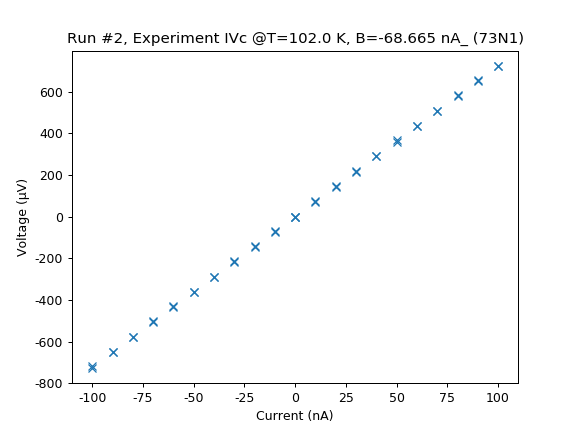

([<matplotlib.axes._subplots.AxesSubplot at 0x45c3610>], [None])

In [21]:
# IVC_udu(amp=100e-9, stp=10e-9, Gain=100, R_bias=50, Attn=1, tfsstb = 0.1, label = '')
plot_by_id(2, marker = 'x', ls = 'None')

<IPython.core.display.Javascript object>


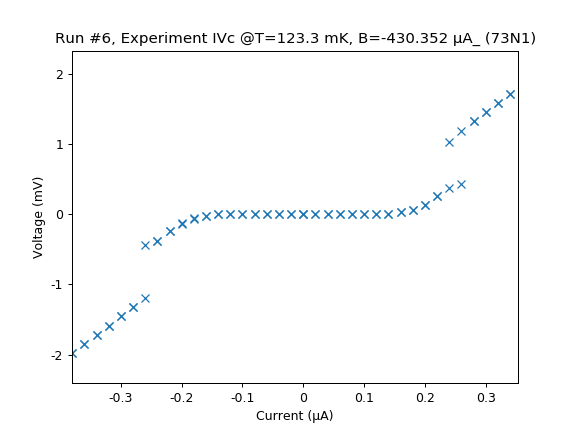

([<matplotlib.axes._subplots.AxesSubplot at 0x9c05cf0>], [None])

In [28]:
plot_by_id(6, marker = 'x', ls = 'None')

In [26]:
plot_by_id(IVC_udu(amp=500e-9, stp=5e-9, Gain=100, R_bias=50, Attn=1, tfsstb = 0.1, label = ''), marker = 'x', ls = 'None')

Starting experimental run with id: 8



<IPython.core.display.Javascript object>

([<matplotlib.axes._subplots.AxesSubplot at 0x9bd63d0>], [None])

In [333]:
cos_to_B(.1, FF = 230e-6, ZF = 0e-6)

0.00021533323100254045

In [ ]:
IVcB_ada(npts_B = 51, thr=250e-6, Gain=100, R_bias=11.2e6, Attn=1, tfsstb = 0.1)

In [348]:
cos_to_B(0.02, FF = 227e-6, ZF = 0e-6)

0.00022410955351517543

In [349]:
cos_to_B(-0.02, FF = 227e-6, ZF = 0e-6)

0.00022989044648482457

In [ ]:
# for cos in np.linspace(.1, -.1, 7) :

# for B in [224e-6,230e-6]:
for cos in [.2] :    
    B = cos_to_B(cos, FF = 227e-6, ZF = 0e-6)
    print(B)
    Bfield.set(B)
    IVC_udu (amp=.5e-9, stp= 0.002e-9, 
             Gain=100, R_bias=101.2e6, Attn=1, tfsstb = 0.1,
             label = 'B = {:1.2f} uA'.format(B*1e6) )

Bfield.set(0)

In [ ]:
Vmeter.init('fast 4')
Blst = cos_to_B(np.linspace(0.4,-0.4,9))
idlst = []
for B in Blst:
    Bfield.set(B)
    idx = IVC_udu (amp=40e-9, stp=0.2e-9, Gain=100, R_bias=11.2e6, Attn=1, tfsstb = 0.1)
    idlst.append(idx)
Bfield.set(0)
print(idlst)

### Histograms

In [ ]:
B = cos_to_B(.25)
Bfield.set(B)
Isws =  meas_hist(1000)
save_hist(Isws)

In [ ]:
meas = set_meas(Vmeter.V, Isrc.I, setup = setup, cleanup = cleanup)

name_exp(sample = SAMPLE, exp_type = 'IVC for hist @T ={:2.1f}mK'.format(T8.get()/1e-3) )  
with meas.run() as datasaver:

    Is, Vs = fast_IVc_adaptive(Gain=100, R_bias=10e6, Attn=1, find_istep = istep_coarse, 
                               keepgoing =  if_Vth, direction = 'p', record = 'u')
    
print(Is)
print(extract_Isw (Is, Vs))


In [320]:
for cos in np.linspace(.1,.25, 7):
    B = cos_to_B(cos)
    Bfield.set(B)
#     IVC_udu (amp=20e-9, stp=.2e-9, Gain=100, R_bias=11.2e6, Attn=1, tfsstb = 0.1)
#     Bfield.set(B)
    Isws =  meas_hist(1000, istep =0.002e-9)
    save_hist(Isws, 'keith, cos = {:1.2f}'.format(cos))
Bfield.set(0)


Starting experimental run with id: 1677
Run # 1677, keith, cos = 0.10 @T =42.3mK saved



Starting experimental run with id: 1678
Run # 1678, keith, cos = 0.12 @T =42.5mK saved



Starting experimental run with id: 1679
Run # 1679, keith, cos = 0.15 @T =42.5mK saved



Starting experimental run with id: 1680
Run # 1680, keith, cos = 0.17 @T =42.1mK saved



Starting experimental run with id: 1681
Run # 1681, keith, cos = 0.20 @T =41.8mK saved


KeyboardInterrupt: 

In [ ]:
Vmeter.init('fast 4')
for t in range(0,35,5):
    save_hist(meas_hist(N=100,t_offset = t/(150e-9*.9/.2e-9)), 'KE delay {}s/it'.format(t))

In [87]:
data = []
for i in range(2,33):
    data.append(i)
print(data)

# just FYI: data = [i for i in range(2,23)] does the same

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
